In [62]:
import pandas as pd
import numpy as np
import json
import re 
import sys
from scipy.sparse import csr_matrix 
import itertools
import cv2
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from skimage import io
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import requests
import os

import warnings
warnings.filterwarnings("ignore")

In [63]:
%matplotlib inline

In [64]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [65]:
df = pd.read_csv('C:\\Users\\Legion\\Desktop\\mood_wala.csv')

In [66]:
spotify_df = df.copy()

In [67]:
spotify_df.shape

(1586, 18)

In [68]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [69]:
ohe_cols = 'popularity'

In [70]:
# create 5 point buckets for popularity 
spotify_df['bucket_popularity'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [72]:
spotify_df.head()

,Unnamed: 0.1,Unnamed: 0,album,track_number,id,name,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,Mood,bucket_popularity
0,0,0,Radhe Shyam,1,7Bnc9gWHdjZAmjSuTY42CJ,Aashiqui Aa Gayi,spotify:track:7Bnc9gWHdjZAmjSuTY42CJ,0.587,0.527,0.495,0.000000,0.127,-7.783,0.0353,122.826,0.474,53,Sad,10
1,1,1,Radhe Shyam,2,4hPxFf3Rd18BRtTYRcqZir,Soch Liya,spotify:track:4hPxFf3Rd18BRtTYRcqZir,0.484,0.597,0.520,0.000001,0.103,-7.624,0.0360,119.923,0.192,54,Sad,10
2,2,2,Radhe Shyam,3,7j1ITbGbqY40RmHMgpTWn2,Udd Jaa Parindey,spotify:track:7j1ITbGbqY40RmHMgpTWn2,0.510,0.555,0.631,0.009250,0.187,-9.910,0.0382,122.011,0.311,34,Sad,6
3,3,3,Radhe Shyam,4,2q4Lxk4MskxCtKjCZaL7IN,Jaan Hai Meri,spotify:track:2q4Lxk4MskxCtKjCZaL7IN,0.693,0.536,0.623,0.000002,0.137,-7.856,0.0743,79.915,0.398,42,Sad,8
4,4,4,Radhe Shyam,5,4B4hRyO842T5th9ucxPQGJ,Main Ishq Mein Hoon,spotify:track:4B4hRyO842T5th9ucxPQGJ,0.598,0.386,0.586,0.000002,0.103,-8.108,0.0474,132.975,0.190,36,Sad,7


In [73]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()
client_id = '3a98f83d33c547668bcd83dbd32eb699'
client_secret = '93f3ad98a52545d0884323e1ad45344a'    

In [74]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [75]:
token = util.prompt_for_user_token(scope, client_id=client_id, client_secret=client_secret, redirect_uri='http://localhost:8400/')

In [76]:
sp = spotipy.Spotify(auth=token)

In [81]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    #list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [82]:
id_name

{'Surprise': '68k3xJAuFWzHVXkTsmeLAL',
 'Neutral': '2iNbFXWYlEurSZufFtmJK0',
 'Sad': '13Vpe8RwF4vKmTlcbfabdX',
 'Fear': '3JOtoVzJkqopjXmaxcuBZf',
 'Disgust': '47oyvzXHlZ84tKAUfe71lV',
 'Angry': '5ur2FjOT6WgyMOiV0p0jME',
 'Happy': '4mluGjfzgdHISqxcgmAt03',
 'Telgu': '6ZSXLok2nhRaepBTFKDmRO',
 'Punjabi': '5qesxpIzXb6KztJTwAz6q6',
 'Morning': '63t2eyGKeUEYA21JbJeOOW',
 'Yo': '00VKfDv9RHDao3gUgVIU4n',
 'Love': '7DPXdbezN1cwYPSRbNaVAy'}

In [83]:
def ChooseDataset(x):
    if x == "Disgust":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Calm'])]
    if x == "Angry":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Calm'])]
    if x == "Fear":
        return spotify_df[spotify_df['Mood'].isin(['Happy', 'Calm'])]
    if x == "Happy":
        return spotify_df[spotify_df['Mood'].isin(['Sad', 'Happy', 'Calm'])]
    if x == "Sad":
        return spotify_df[spotify_df['Mood'].isin(['Sad', 'Happy', 'Calm'])]
    if x == "Surprise":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Sad'])]
    return spotify_df

In [84]:
from tensorflow.keras.models import load_model

loaded_model = load_model('D:\\Music-recommendation-based-on-facial-emotion-recognition-main (1)\\Music-recommendation-based-on-facial-emotion-recognition-main\\new_img_data\\model.keras', compile = True)

In [85]:
def Recommend_Music(emotion, df, features, nonplaylist_features):
    """ 
    Recommend songs based on the user's emotion.

    Parameters: 
        emotion (str): The user's most recent emotion.
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        recommended_songs_df: Recommended songs based on the emotion
    """
    
    # Filter songs based on the emotion (you may need to customize this based on your dataset)
    emotion_filtered_df = df[df['emotion_column'] == emotion]
    
    # Calculate features for the emotion-filtered songs
    emotion_filtered_features = Feature_Set_Using_TDiDF(emotion_filtered_df, float_cols=float_cols)
    
    # Combine the emotion-specific features with the overall features
    combined_features = features + emotion_filtered_features.mean(axis=0)
    
    # Recommended Songs
    recommended_songs_df = Recommend_Playlist(df, combined_features, nonplaylist_features)
    
    return recommended_songs_df.head(10)

In [86]:
def One_Hot_Encode_Prep(df, column, new_name):
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop=True, inplace=True)
    return tf_df

# Function to build entire feature set
def Feature_Set_Using_TDiDF(df):
    # Selecting relevant columns
    selected_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness',
                     'loudness', 'speechiness', 'tempo', 'valence', 'popularity']

    floats = df[selected_cols].reset_index(drop=True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns=floats.columns) * 0.2

    final = pd.concat([floats_scaled], axis=1)
    final['id'] = df['id'].values

    return final



# Function to pull songs from a specific playlist
def Get_Spotify_Playlist_DataFrame(playlist_name, id_dic, df):
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        playlist.loc[ix, 'artist'] = i['track']['album']['artists'][0]['name']
        #playlist.loc[ix, 'album'] = i['track_number']['album']['name']
        playlist.loc[ix, 'id'] = i['track']['id']
        # No 'url' or 'added_at' columns since they are not available in your dataset
        playlist.loc[ix, 'track_name'] = i['track']['name']

    playlist = pd.merge(playlist, df, how='inner', on='id')
    return playlist

# Modified function to generate playlist features
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    playlist_features_in_dataframe = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]
    playlist_features_in_dataframe = playlist_features_in_dataframe.merge(playlist_df[['id']], on='id', how='inner')

    # Check if the playlist is not empty
    if not playlist_features_in_dataframe.empty:
        playlist_features_not_in_dataframe = complete_feature_set[
            ~complete_feature_set['id'].isin(playlist_df['id'].values)]

        playlist_feature_set = playlist_features_in_dataframe.copy()

        # No date_added column to consider

        # Weight calculation based on some logic (you can customize this part)
        playlist_feature_set['weight'] = playlist_feature_set.index.to_series().apply(lambda x: weight_factor ** (-x))

        # Apply the weights to the features
        playlist_feature_set_weighted = playlist_feature_set.copy()
        playlist_feature_set_weighted.update(
            playlist_feature_set_weighted.iloc[:, :-2].mul(playlist_feature_set_weighted.weight, 0))
        playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-2].mean(axis=0)

        return playlist_feature_set_weighted_final, playlist_features_not_in_dataframe
    else:
        # Handle the case where the playlist is empty
        return None, None


# Function to recommend songs
def Recommend_Playlist(spotify_df, features_in_the_playlist, features_not_in_the_playlist):
    # Recommendation logic here
    # ...

    # Dummy data, replace with your recommendation logic
    
    recommended_songs = spotify_df.sample(10)
    recommended_songs = recommended_songs[['name', 'album','uri','id']]
    return recommended_songs



def get_spotify_track_image(track_id, spotify_token):
    headers = {
        'Authorization': f'Bearer {spotify_token}',
    }

    # Spotify API endpoint to get track details
    endpoint = f'https://api.spotify.com/v1/tracks/{track_id}'
    
    # Make a GET request to the Spotify API
    response = requests.get(endpoint, headers=headers)
    
    if response.status_code == 200:
        # Extract the image URL from the API response
        image_url = response.json()['album']['images'][0]['url']
        return image_url
    else:
        # If the request fails, return None
        return None

def visualize_songs(top40_recommendation, spotify_token):
    temp = top40_recommendation['id'].values
    plt.figure(figsize=(15, int(0.625 * len(temp))))
    columns = 5
    
    for i, track_id in enumerate(temp):
        # Get the image URL for the track from Spotify API
        image_url = get_spotify_track_image(track_id, spotify_token)
        
        if image_url:
            plt.subplot(int(len(temp) / columns) + 1, columns, i + 1)
            image_content = requests.get(image_url).content
            image = io.imread(image_content, plugin='imageio')
            plt.imshow(image)
            plt.xticks(color='w', fontsize=0.1)
            plt.yticks(color='w', fontsize=0.1)
            plt.xlabel(top40_recommendation['name'].values[i], fontsize=12)
            plt.tight_layout(h_pad=0.4, w_pad=0)
            plt.subplots_adjust(wspace=None, hspace=None)
    
    plt.show()
    
    print(top40_recommendation)

# Main function for recommendation
def Recommend_Top40(emotions, loaded_model, spotify_df):
    # Choose the dataset based on the emotion
    emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    emotion = emotion_dict[emotions[-1]]  # Use the most recent emotion

    O_df = ChooseDataset(emotion)

    # Feature Engineering from the main dataframe
    float_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo',
                  'valence']
    complete_feature_set = Feature_Set_Using_TDiDF(O_df)

    # Collecting the Spotify user playlist dataframe
    one_playlist_from_spotify = Get_Spotify_Playlist_DataFrame(emotion, id_name, O_df)

    # Linear vector for recommendation
    features_in_the_playlist, features_not_in_the_playlist = generate_playlist_feature(complete_feature_set,
                                                                                         one_playlist_from_spotify, 1.09)

    # Recommended Songs stored here
    top40_recommendation = Recommend_Playlist(spotify_df, features_in_the_playlist, features_not_in_the_playlist)
    print("Detected Emotion is :- ",emotion)
    # Visualize recommended songs
    visualize_songs(top40_recommendation,token)

In [87]:
def moodNamePrintFromLabel(n):
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    return emotions[n]

# Function to capture video from webcam and perform emotion detection
def capture_and_detect_emotion(model):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    video_cap = cv2.VideoCapture(0)  # Open the webcam

    emotions = []
    start_time = cv2.getTickCount()

    while (video_cap.isOpened()):
        ret, frame = video_cap.read()

        if not ret:
            print("Failed to capture frame")
            break

        gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)

        for (x, y, w, h) in faces:
            pxl_lst = []
            for i in range(y, y + h):
                lst = []
                for j in range(x, x + w):
                    lst.append(gray_img[i][j])
                pxl_lst.append(lst)
            single_face = np.array(pxl_lst)

            resized_img = cv2.resize(single_face, (48, 48), interpolation=cv2.INTER_AREA)
            resized_img = np.reshape(resized_img, (1, 48, 48, 1)) / 255.0

            # Get the result from the model
            result = np.argmax(model.predict(resized_img), axis=-1)

            # Draw a rectangle around the face and display the mood label
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(frame, moodNamePrintFromLabel(result[0]), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                        (255, 0, 0), 2)

            emotions.append(result[0])

        # Display the frame with mood information
        cv2.imshow('Webcam Mood Detection', frame)

        current_time = cv2.getTickCount()
        elapsed_time = (current_time - start_time) / cv2.getTickFrequency()

        if elapsed_time >= 5:
            break  # Break after 5 seconds

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close the window
    video_cap.release()
    cv2.destroyAllWindows()

    return emotions

1/1 [==============================] - 0s 32ms/step
Detected Emotion is :-  Happy


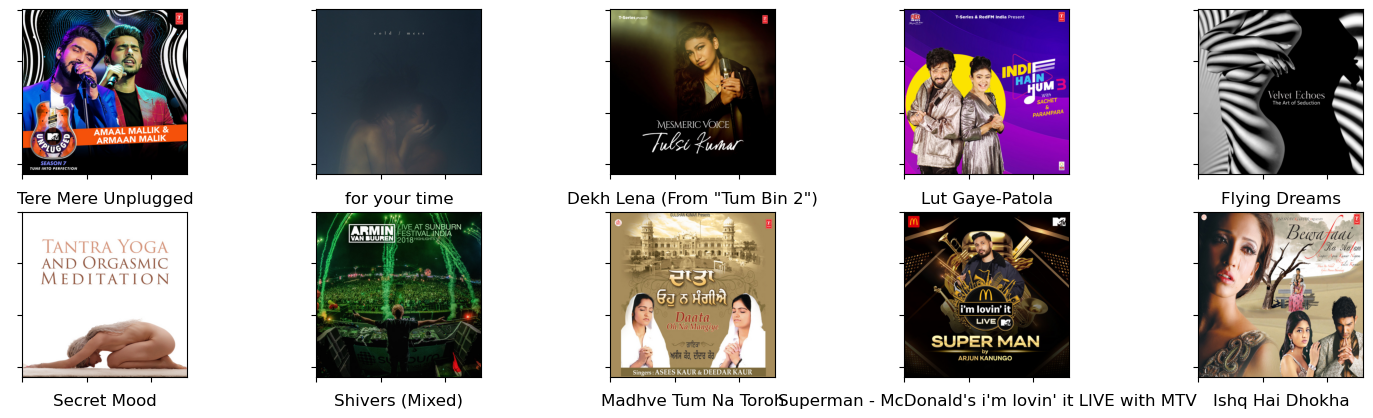

                                                   name  \
30                                  Tere Mere Unplugged   
385                                       for your time   
768                        Dekh Lena (From "Tum Bin 2")   
973                                     Lut Gaye-Patola   
1311                                      Flying Dreams   
1443                                        Secret Mood   
220                                     Shivers (Mixed)   
1034                                Madhve Tum Na Toroh   
120   Superman - McDonald's i'm lovin' it LIVE with MTV   
830                                     Ishq Hai Dhokha   

                                                  album  \
30    Amaal Mallik & Armaan Malik - Mtv Unplugged Se...   
385                                           cold/mess   
768                        Mesmeric Voice - Tulsi Kumar   
973            Indie Hain Hum 3 With Sachet & Parampara   
1311  Velvet Echoes: The Art of Seduction – Valentin...

In [89]:
# Capture emotions from webcam
emotions = capture_and_detect_emotion(loaded_model)

# Recommend songs based on the most recent emotion
Recommend_Top40(emotions, loaded_model, spotify_df)